# Age Regression with Keras

In this notebook you will set up regression models outputs a gaussian conditional probability distribution.
You will model the conditional probability distribution $p(y|x)$ as a Normal distribution.

**Dataset:**
You work with a the [UTKFace dataset](https://susanqq.github.io/UTKFace/). It has a large age span (range from 0 to 116 years old). The dataset consists of over 20,000 face images with annotations of age, gender, and ethnicity. The data is already preprocessed and rescaled (80x80 pixels) so you can work with it. You will only use the information of the age and image.


**GPU:**
It is better to use the GPU for this notebook. If you are using colab, you can change the runtime type in the menu: Runtime -> Change runtime type -> Hardware accelerator -> GPU.

**Your Task**
Steps through the notebook and try to understand the code. The code is already quite complete, fill out the cells with (🔧 YOUR TASK)

#### Settings

A negative number of EPOCHS loads the trained weights.

In [58]:
EPOCHS = 15   #Change this to smaller number for testing, negative means load the weights from dropbox (only for JAX)
# Note only tested for JAX backend
BACKEND = 'TORCH' #Change this to 'JAX' or 'TORCH' 

In [59]:
### Running on Colab
import sys
import time
IN_COLAB = 'google.colab' in sys.modules
print(f"Running on Colab: {IN_COLAB}")

Running on Colab: False


##### Setting the backend

In [60]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as imgplot
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from pylab import *

from PIL import Image
import numpy as np
from tqdm import tqdm

import time
import os
os.environ["KERAS_BACKEND"] = "torch"
import keras
import torch

print(f'Keras_version: {keras.__version__}')# 3.5.0
print(f'torch_version: {torch.__version__}')# 2.5.1+cu121
print(f'keras backend: {keras.backend.backend()}')

cuda_available = torch.cuda.is_available()
cuda_version = torch.version.cuda if cuda_available else "N/A"
print(f"CUDA Available: {cuda_available}")
print(f"CUDA Version: {cuda_version}")


# Keras Building blocks
from keras.models import Sequential
from keras.layers import Dense, Convolution2D, MaxPooling2D, Flatten , Activation
from keras.optimizers import SGD
from keras.utils import to_categorical
from keras import optimizers

import sys
from IPython.display import display, Markdown

##### We import Keras (after setting the backend)
from keras import layers, Input, Model
from keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.layers import Dense, Convolution2D, MaxPooling2D, Flatten , Activation, Dropout, Input, Concatenate
import keras.backend as K


import numpy as np

import urllib

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pickle

from tqdm.keras import TqdmCallback # train the model

# Check for CUDA (NVIDIA GPU) availability
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("✅ CUDA is available. Using GPU.")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")

# Check for MPS (Apple Silicon GPU) availability
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("✅ MPS (Apple Silicon GPU) is available. Using MPS.")

# Default to CPU if neither CUDA nor MPS is available
else:
    device = torch.device("cpu")
    print("❌ No GPU available. Using CPU.")

print(f"Device selected: {device}")

Keras_version: 3.8.0
torch_version: 2.5.1
keras backend: torch
CUDA Available: False
CUDA Version: N/A
✅ MPS (Apple Silicon GPU) is available. Using MPS.
Device selected: mps


#### Loading the data, if it is not loaded

In [61]:
if not os.path.isfile('X_faces.npy'):
    urllib.request.urlretrieve(
    "https://www.dropbox.com/s/5m7nmebpjysqtus/X_faces.npy?dl=1",
    "X_faces.npy")
!ls -lh X_face*

if not os.path.isfile('Y_age.npy'):
    urllib.request.urlretrieve(
    "https://www.dropbox.com/s/flpyvgdqoatdw0g/Y_age.npy?dl=1",
    "Y_age.npy")
!ls -lh Y*

-rw-r--r--  1 oli  staff   434M Feb 13 14:00 X_faces.npy
-rw-r--r--  1 oli  staff    93K Feb 13 14:00 Y_age.npy


In [62]:
X=np.load("X_faces.npy")
Y=np.load("Y_age.npy")

#### Splitting the data into train, val and test dataset

In [63]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=201)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=34)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(10642, 80, 80, 3)
(5242, 80, 80, 3)
(7824, 80, 80, 3)


#### Looking at a few image samples

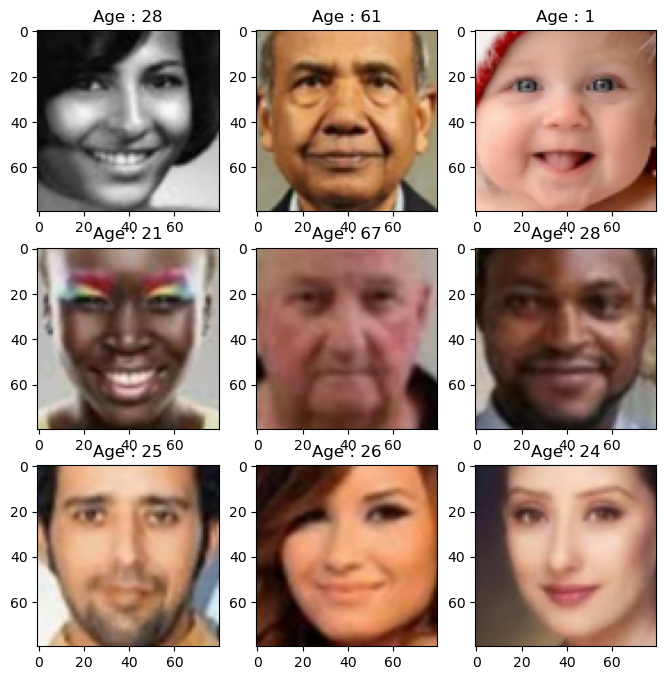

In [64]:
plt.figure(figsize=(8,8))
for i in range(0,9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_train[i])
    plt.title("Age : "+ str(y_train[i]))
plt.show()

#### Normalize the data

In [65]:
X_train=X_train/255
X_val=X_val/255
X_test=X_test/255
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(10642, 80, 80, 3)
(5242, 80, 80, 3)
(7824, 80, 80, 3)


#### Looking at the age distribution

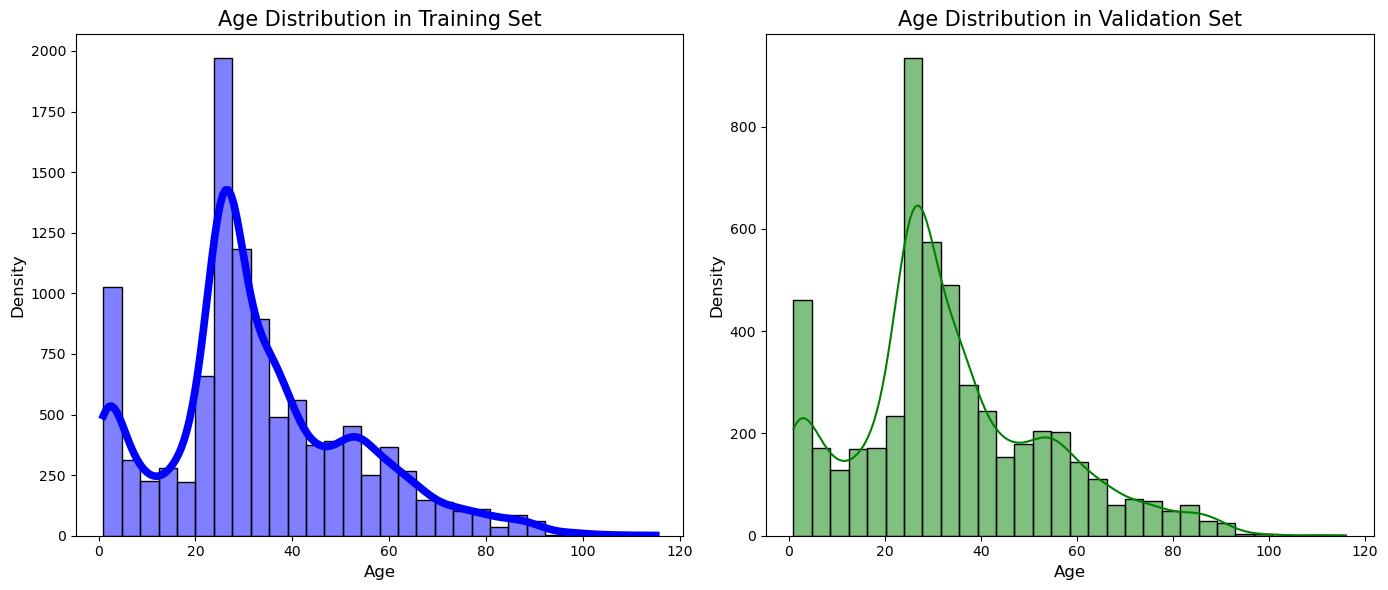

In [66]:
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
sns.histplot(y_train, bins=30, kde=True, color='blue', line_kws={'linewidth': 5.5})
plt.title("Age Distribution in Training Set", fontsize=15)
plt.xlabel("Age", fontsize=12)
plt.ylabel("Density", fontsize=12)

plt.subplot(1,2,2)
sns.histplot(y_val, bins=30, kde=True, color='green')
plt.title("Age Distribution in Validation Set", fontsize=15)
plt.xlabel("Age", fontsize=12)
plt.ylabel("Density", fontsize=12)

plt.tight_layout()
plt.show()

#### 🔧 **Exercise 1:** implement Naive Model

Use a naive model, which simply predicts a Gaussian describing the marginal age distribution. 

##### i) Estimation of $\mu$ and $\sigma$

You should get $\hat{\mu} \approx 33.14$ and $\hat{\sigma} \approx 19.81$.

##### ii) Calculate the NLL on the testset

Use the density function of the normal distribution to calculate the negative log likelihood (NLL) of the testset. You should get a NLL of $\approx 4.4$.

Recall the density function of the normal distribution:
$$
p(y) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(y-\mu)^2}{2\sigma^2}\right)
$$

In [67]:
#### 🔧 YOUR TASK ########
#### 🎯 Solution ########

# i) NLL
mu_naive = np.mean(y_train)
sd_naive = np.std(y_train)

print(f"mu_naive: {mu_naive}")
print(f"sd_naive: {sd_naive}")

# ii) Calculate NLL on testset
nll_naive = 0
for i in range(len(X_test)):  # Iterate over the entire test set
    # Calculate the log probability using NumPy
    log_prob = -0.5 * np.log(2 * np.pi * sd_naive**2) - (y_test[i] - mu_naive)**2 / (2 * sd_naive**2)
    nll_naive -= log_prob  # Accumulate negative log probability

nll_naive /= len(X_test)  # Average the NLL over the test set

print(f"NLL for naive prediction (NumPy): {nll_naive}")

mu_naive: 33.145555346739336
sd_naive: 19.811519163323144
NLL for naive prediction (NumPy): 4.409863107213443


#### Prepare Data 


Note that the reshape is extremly important. This makes the shape of y from $(B,)$ to $(B,1)$ a shape of $(B,)$ will cause strange broadcast errors. To check remove the reshape and train again.

In [68]:
#We only need float32
X_train = np.array(X_train,dtype="float32")
X_val = np.array(X_val,dtype="float32")
X_test = np.array(X_test,dtype="float32")

##### NOTE THE RESHAPE IS EXTREMLY IMPORTANT ####
y_train = np.array(y_train,dtype="float32").reshape(-1,1) #⚠️ w/o reshape no training beyond naive model
y_val = np.array(y_val,dtype="float32").reshape(-1,1)     #⚠️
y_test = np.array(y_test,dtype="float32").reshape(-1,1)   #⚠️

X_train = torch.tensor(X_train).float().to(device)
X_val = torch.tensor(X_val).float().to(device)
X_test = torch.tensor(X_test).float().to(device)
y_train = torch.tensor(y_train).float().to(device)
y_val = torch.tensor(y_val).float().to(device)
y_test = torch.tensor(y_test).float().to(device)

print(X_train.mean())
print(X_val.mean())
print(X_val.mean())

print(y_train.shape) #Need to have the last dimension of ,1

tensor(0.4780, device='mps:0')
tensor(0.4775, device='mps:0')
tensor(0.4775, device='mps:0')
torch.Size([10642, 1])


### Output of NN to Gaussian Distribution

The output NN has the form (B, 2) with the first dimension. The last two dimensions code the mean and the log(sd) of the Gaussian.

In [69]:
# Wrapper function to convert model output to a PyTorch Normal distribution
import torch
from torch.distributions import Normal

@staticmethod
def output_to_gaussian_distribution(output):
    mean = output[:, :1]
    log_variance = output[:, 1:]
    scale = torch.exp(log_variance)  # Ensure positive scale
    return torch.distributions.Normal(loc=mean, scale=scale)

def NLL(y_true, output):
  dist = output_to_gaussian_distribution(output)
  return -dist.log_prob(y_true).mean()

## Fit a regression model with flexible variance
In the next cells you will again define and fit a model on the face images. You will use a CNN to model the mu parameter of a gaussian conditional probability distribution, but this time the sigma will not be constant for all inputs. Every iamge will be able to have a different sigma. For the loss we use the NLL.

In [70]:
kernel_size = (3, 3)
pool_size = (2, 2)
input1 = Input(shape=(80,80,3))
x = Convolution2D(16,kernel_size,padding='same',activation="relu")(input1)
x = Convolution2D(16,kernel_size,padding='same',activation="relu")(x)
x = MaxPooling2D(pool_size=pool_size)(x)

x = Convolution2D(32,kernel_size,padding='same',activation="relu")(x)
x = Convolution2D(32,kernel_size,padding='same',activation="relu")(x)
x = MaxPooling2D(pool_size=pool_size)(x)

x = Convolution2D(32,kernel_size,padding='same',activation="relu")(x)
x = Convolution2D(32,kernel_size,padding='same',activation="relu")(x)
x = MaxPooling2D(pool_size=pool_size)(x)
x = Flatten(name = 'bef_split')(x)

# One HEAD
x = Dense(2*500, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(2*50, activation="relu")(x)
x = Dropout(0.3)(x)
mean_and_sd_layer = Dense(2)(x)

model_flex = Model(inputs=input1, outputs=mean_and_sd_layer)
model_flex.compile(keras.optimizers.Adam(), loss=NLL)
model_flex.summary()



Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 80, 80, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 80, 80, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 80, 80, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 40, 40, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 40, 40, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 40, 40, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 20, 20, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 20, 20, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 20, 20, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 10, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bef_split (Flatten)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1000)           │     3,201,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 100)            │       100,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,336,454 (12.73 MB)

 Trainable params: 3,336,454 (12.73 MB)

 Non-trainable params: 0 (0.00 B)

In [71]:
model_flex(X_train[0:10]), y_train[0:10]

(tensor([[ 0.0127, -0.0371],
         [ 0.0294, -0.0355],
         [ 0.0332, -0.0413],
         [ 0.0154, -0.0259],
         [ 0.0198, -0.0337],
         [ 0.0088, -0.0356],
         [ 0.0410, -0.0407],
         [ 0.0219, -0.0377],
         [ 0.0289, -0.0317],
         [ 0.0375, -0.0479]], device='mps:0', grad_fn=<AddBackward0>),
 tensor([[28.],
         [61.],
         [ 1.],
         [21.],
         [67.],
         [28.],
         [25.],
         [26.],
         [24.],
         [31.]], device='mps:0'))

In [72]:
print(X_train.shape, y_train.shape)

torch.Size([10642, 80, 80, 3]) torch.Size([10642, 1])


In [73]:
history=model_flex.fit(X_train, y_train, epochs=EPOCHS, verbose=0)
                      

RuntimeError: view size is not compatible with input tensor's size and stride (at least one dimension spans across two contiguous subspaces). Use .reshape(...) instead.

In [41]:
if (EPOCHS > 0):
  history=model_flex.fit(X_train, y_train,
                      epochs=EPOCHS,
                      verbose=0,
                      validation_data=(X_val, y_val),
                      callbacks=[TqdmCallback(verbose=1)]
                    )
  model_flex.save_weights('model_flex.weights.h5')
  # Save history files
  with open('history.pkl', 'wb') as f:
      pickle.dump(history.history, f)
  plt.plot(history.history['loss'], label = 'Training Loss')
  plt.plot(history.history['val_loss'], label = 'Validation Loss')
  plt.axhline(y=nll_naive, color='r', linestyle='--', label='Naive NLL')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss')
  plt.ylim(0, 7)
  plt.legend()
  plt.show()
else:
    print("Downloading weights ...")
    import requests
    # Define the URL and the local file path
    url = 'https://www.dropbox.com/scl/fi/7lgbkld4u55b70kt5rwqz/model_flex.weights.h5?rlkey=oxf9g4cyfit3pjuu71t2sltlb&dl=1'
    local_file = 'model_flex.weights.h5'

    # Check if the file already exists
    if not os.path.exists(local_file):
        # Download the file if it does not exist
        response = requests.get(url)
        with open(local_file, 'wb') as f:
            f.write(response.content)

    # Load the weights from the local file
    model_flex.load_weights(local_file)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

RuntimeError: view size is not compatible with input tensor's size and stride (at least one dimension spans across two contiguous subspaces). Use .reshape(...) instead.

#### Look at the predicted mean and the predicted sigma of the CPD on the testset


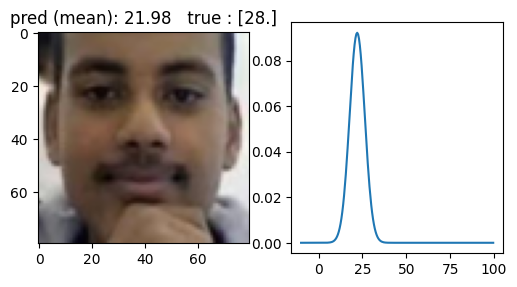

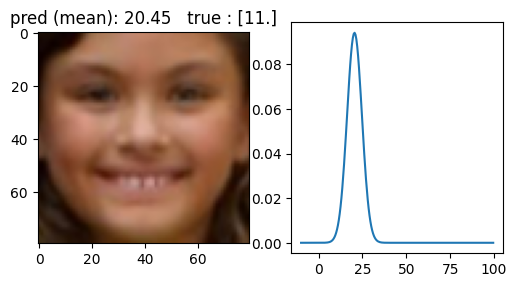

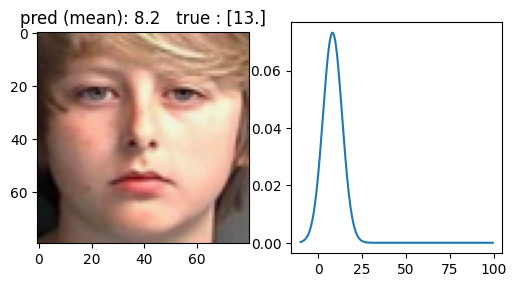

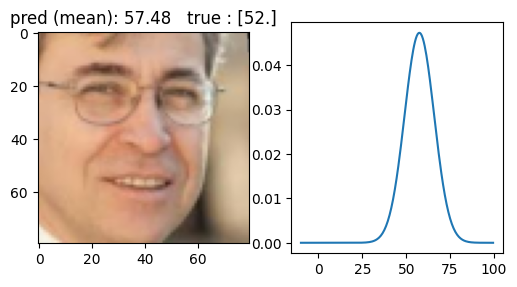

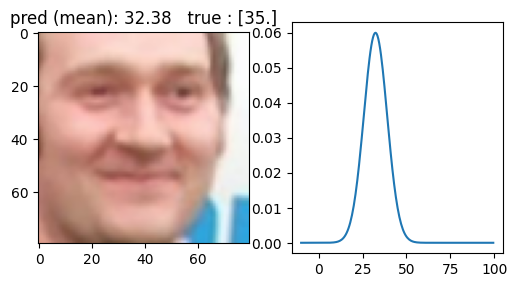

In [50]:
ages = np.arange(-1,100,0.5)

for i in range(0,5):
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    plt.imshow(X_test[i])

    mu_sigma = model_flex(X_test[i:i+1])
    mu = mu_sigma[0, 0]
    sigma = np.exp(mu_sigma[0, 1])

    plt.title("pred (mean): "+ str(round(float(mu), 2)) +
            "   true : "+ str(y_test[i]))
    d = dist.Normal(loc=mu, scale=sigma)
    plt.subplot(1,2,2)
    ys = jnp.arange(-10,100,0.5)
    plt.plot(ys, np.exp(d.log_prob(ys)))
    plt.show()

# 🔧 Exercise 2 (Calculate Model Preformance)

Calculate the NLL for the testset. For that write a function that has the API of a score. The function should take the observed/true `y_observed` values and the predicted CPD $p_{\tt{pred}}(y|x)$ as input (called `py_given_x`) and return the NLL. Here is the core of the function:

```python
def score(py_given_x, y_observed):
    # py_given_x: the predicted CPD as a tfp.distributions object
    # y_observed: the observed/true values
    # return: Score (lower is better forecast)
    # YOUR CODE HERE
```

Which other scores/metrics could you use to compare the models, which once should you not use?

For partical reasons the network needs to be transformed to a distribution, using the function `output_to_gaussian_distribution`. This function is already implemented in the notebook.

```python
def NLL(out_network, y):
    dist = output_to_gaussian_distribution(out_network)
    ... YOUR CODE HERE ...
```

### Solution to the exercise (remove this code)

In [90]:
def NLL(distr, y):
    d = output_to_gaussian_distribution(distr)
    return -d.log_prob(y)

In [91]:
# Looping over all test samples takes aboyt 1-2 minutes on a mac book pro m2
from tqdm import tqdm

# Alternative way to compute NLL
### Looping over all test samples takes about 1-2 minutes on a mac book pro m2
nll_flex = 0
steps = len(X_test)
steps = 1000  #Hack for fast calculation
for i in tqdm(range(steps), desc='Calculating NLL'):
  nll_flex += NLL(model_flex(X_test[i:i+1]), y_test[i])

print("NLL for flexible sigma model: ", nll_flex/steps)

Calculating NLL: 100%|██████████| 1000/1000 [00:02<00:00, 391.27it/s]

NLL for flexible sigma model:  [[3.9316616]]


**Answer** There are other strictly proper socring rules that can be used to evaluate the performance of a probabilistic model.
One of them is the CRPS (Continuous Ranked Probability Score). The CRPS is a strictly proper scoring rule for the continuous case.
You should not use mean squared error or mean absolute error to evaluate the performance of a probabilistic model.

In [53]:
# Since the NLL is also the loss function, we can also use the evaluate function of keras. Which is much faster.
nll_flex = model_flex.evaluate(X_test,y_test,verbose=0)

print("NLL for flexible sigma model: ", nll_flex)

NLL for flexible sigma model:  3.989995241165161


# 🔧 Exercise 3 (Find most certain preds)
Find the 5 person of the test set the model is most certain about and plot the together with the predicted CPD.

### Solution to the exercise (remove this code)

In [92]:
# We use a batch size of 100 to avoid memory issues
batch_size = 100  # Adjust this value based on your memory capacity
uncertainty_flex = []
uncertainty_flex = model_flex.predict(X_test)
uncertainty_flex = np.array(uncertainty_flex)

245/245 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step


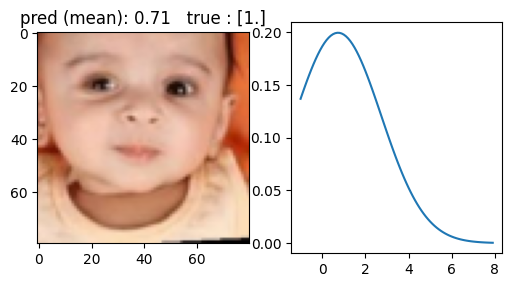

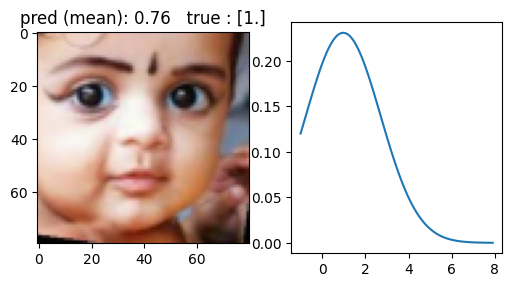

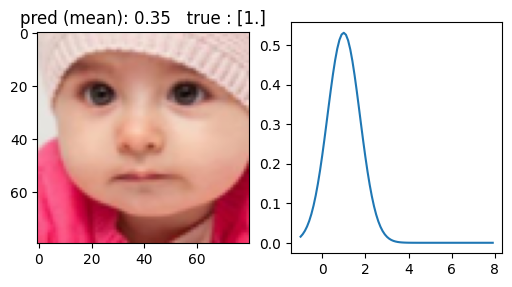

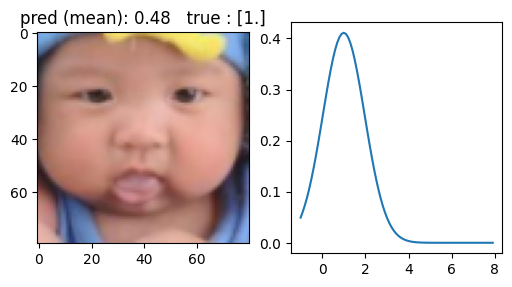

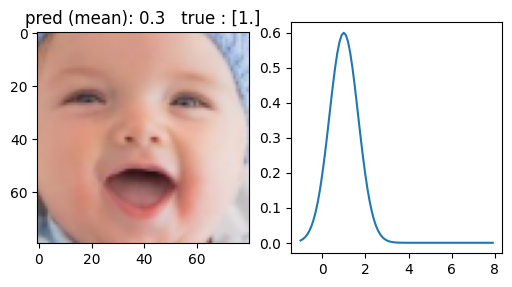

In [93]:
#Sort the list and find the 5 highest values
indices = np.argsort(uncertainty_flex[:,0])[:5]
ages = np.arange(-1,8,0.1)
for i in indices:
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    plt.imshow(X_test[i])
    plt.title("pred (mean): "+ str(round(float(model_flex(X_test[i:i+1]).mean()),2)) +
            "   true : "+ str(y_test[i]))
    ds = output_to_gaussian_distribution(model_flex(X_test[i:i+1])).log_prob(ages)
    plt.subplot(1,2,2)
    plt.plot(ages, np.exp(ds)[0])
    plt.show()


# 🔧 Exercise 4 PIT-Histograms

Create a so-called PIT histgram (Probability Integral Transform) to check if the model is calibrated. For that take calculate the values of the cumulative distribution function (CDF) of the predicted distribution evaluated at the observed ages. Then plot a histogram of these values. The histogram should be uniform if the model is calibrated. Describe your findings.


Hint: You can use the function `scipy.stats.norm.cdf` to calculate the CDF of the normal distribution.

In [96]:
d  =  model_flex(X_test)
mu = d[:,0].reshape(-1,1) # reshape to 2D array
sigma = np.exp(d[:,1]).reshape(-1,1)
pit_values = stats.norm.cdf(y_test, loc=mu, scale=sigma)

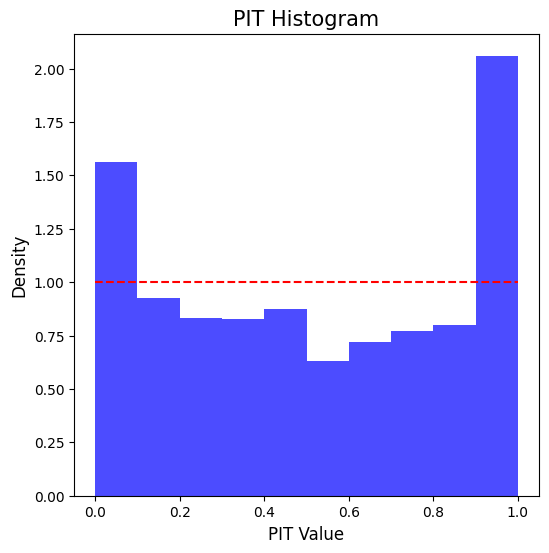

In [97]:
# Plot the PIT histogram
plt.figure(figsize=(6, 6))
plt.hist(pit_values, bins=10, color='blue', alpha=0.7, density=True)
plt.plot([0, 1], [1, 1], color='red', linestyle='--')
plt.title("PIT Histogram", fontsize=15)
plt.xlabel("PIT Value", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.show()

So clearly the model underestimates the tails.

# Suggestion for further exercises (optional)

The gausian distribution is not the best distribution to model the age. For example the [Log-Normal](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/LogNormal). This would give you a model that is not able to predict negative ages. And the result would look like:


![Screenshot 2024-01-07 at 15.13.51.png](imgs/img1.png)

and
![Screenshot 2024-01-07 at 15.13.39.png](imgs/img2.png))
